# Toto: Zero-Shot Blood Glucose Forecasting

This notebook demonstrates zero-shot forecasting using Toto (Time-Series-Optimized Transformer for Observability).

**Model**: Datadog/Toto-Open-Base-1.0 (151M parameters, trained on 2T data points)  
**Dataset**: Kaggle BrisT1D  
**Task**: 8-hour nocturnal blood glucose forecasting  

**Installation**: `pip install toto-ts`  
**Note**: Toto provides probabilistic forecasting with quantiles!

## Setup and Data Loading

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from toto.model.toto import Toto
from toto.data.util.dataset import MaskedTimeseries
from toto.inference.forecaster import TotoForecaster

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Using torch {torch.__version__}")
print(f"✅ Using device: {device}")

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venv/lib/python3.12/site-packages/lightning/fabric/__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


✅ Using torch 2.7.0
✅ Using device: cpu


In [2]:
# Load Kaggle BrisT1D dataset
loader = get_loader(
    data_source_name="kaggle_brisT1D", 
    dataset_type="train", 
    use_cached=True
)

2025-12-05T00:00:41 - ============================================================
2025-12-05T00:00:41 - Beginning data loading process with the following parmeters:
2025-12-05T00:00:41 - 	Dataset: kaggle_brisT1D - train
2025-12-05T00:00:41 - 	Columns: None
2025-12-05T00:00:41 - 	Generic patient start date: 2024-01-01 00:00:00
2025-12-05T00:00:41 - 	Number of validation days: 20
2025-12-05T00:00:41 - 	In parallel with up to 3 workers.

2025-12-05T00:00:43 - Loaded full processed data from cache for 9 patients
2025-12-05T00:00:43 - Loaded existing train/validation split from cache for 9 patients


## Configuration

In [3]:
# Time series configuration (same as TEMPO/Chronos notebooks)
INTERVAL_MINS = 5
TRAIN_HOURS = 40  # Context length: 40 hours of history
PREDICTION_HOURS = 8  # Forecast: 8 hours ahead

prediction_length = int((PREDICTION_HOURS * 60) / INTERVAL_MINS)  # 96 timesteps
context_length = int(TRAIN_HOURS * 60 / INTERVAL_MINS)  # 480 timesteps

print(f"Context length: {context_length} timesteps ({TRAIN_HOURS} hours)")
print(f"Prediction length: {prediction_length} timesteps ({PREDICTION_HOURS} hours)")

# Target column
TARGET_COL = ColumnNames.BG.value
print(f"\nTarget: {TARGET_COL}")

Context length: 480 timesteps (40 hours)
Prediction length: 96 timesteps (8 hours)

Target: bg_mM


## Load Toto Model

In [4]:
# Load pretrained Toto model from HuggingFace
print("Loading Toto model from HuggingFace...")
toto = Toto.from_pretrained('Datadog/Toto-Open-Base-1.0')
toto.to(device)

# Create forecaster
forecaster = TotoForecaster(toto.model)
print("Toto model loaded successfully!")

Loading Toto model from HuggingFace...
Toto model loaded successfully!


## Zero-Shot Evaluation on Validation Set

In [6]:
# Get validation data from loader
if loader.validation_data is None:
    raise ValueError("No validation data found")

val_data: dict[str, pd.DataFrame] = loader.validation_data

# Evaluation metrics storage
all_predictions = []
all_targets = []
patient_metrics = []

print(f"Evaluating Toto on {len(val_data)} patients...\\n")

for patient_id, patient_df in val_data.items():
    # Skip if not 5-minute intervals
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        print(f"Skipping {patient_id}: interval not {INTERVAL_MINS} minutes")
        continue
    
    # Skip if not enough data
    if len(patient_df) < context_length + prediction_length:
        print(f"Skipping {patient_id}: insufficient data")
        continue
    
    print(f"Processing {patient_id}...")
    
    # Extract target column as numpy array
    target_data = patient_df[TARGET_COL].values
    timestamps = patient_df.index
    
    # Make predictions on sliding windows (limit to 5 for speed)
    patient_preds = []
    patient_targets = []
    
    num_windows = 0
    max_windows = 5
    
    for i in range(len(target_data) - context_length - prediction_length + 1):
        context = target_data[i:i+context_length]
        target = target_data[i+context_length:i+context_length+prediction_length]
        context_timestamps = timestamps[i:i+context_length]
        
        # IMPORTANT: Skip windows with NaN values
        # Unlike Chronos/TEMPO, Toto does NOT handle NaN internally!
        if np.isnan(context).any() or np.isnan(target).any():
            continue
        
        # Prepare Toto input
        series_tensor = torch.tensor(context, dtype=torch.float32).unsqueeze(0).to(device)
        padding_mask = torch.ones_like(series_tensor, dtype=torch.bool)
        id_mask = torch.zeros_like(series_tensor)
        timestamp_seconds = torch.tensor(
            [ts.timestamp() for ts in context_timestamps],
            dtype=torch.float32
        ).unsqueeze(0).to(device)
        time_interval = torch.tensor([INTERVAL_MINS * 60], dtype=torch.float32).to(device)
        
        inputs = MaskedTimeseries(
            series=series_tensor,
            padding_mask=padding_mask,
            id_mask=id_mask,
            timestamp_seconds=timestamp_seconds,
            time_interval_seconds=time_interval,
        )
        
        # Toto prediction (zero-shot)
        with torch.no_grad():
            forecast = forecaster.forecast(
                inputs,
                prediction_length=prediction_length,
                num_samples=100,  # Reduced for speed
                samples_per_batch=50,
            )
            pred = forecast.median.cpu().numpy().flatten()
        
        patient_preds.append(pred)
        patient_targets.append(target)
        
        num_windows += 1
        if num_windows >= max_windows:
            break
    
    if len(patient_preds) > 0:
        patient_preds = np.array(patient_preds)
        patient_targets = np.array(patient_targets)
        
        # Compute metrics
        mse = np.mean((patient_preds - patient_targets) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(patient_preds - patient_targets))
        
        patient_metrics.append({
            'patient_id': patient_id,
            'rmse': rmse,
            'mae': mae,
            'num_windows': len(patient_preds)
        })
        
        all_predictions.extend(patient_preds.flatten())
        all_targets.extend(patient_targets.flatten())
        
        print(f"  {patient_id}: RMSE={rmse:.3f}, MAE={mae:.3f} ({len(patient_preds)} windows)")

# Overall metrics
if len(all_predictions) > 0:
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    overall_rmse = np.sqrt(np.mean((all_predictions - all_targets) ** 2))
    overall_mae = np.mean(np.abs(all_predictions - all_targets))
    overall_mape = np.mean(np.abs((all_predictions - all_targets) / (all_targets + 1e-8))) * 100
    
    print("\\n" + "="*60)
    print("Toto Zero-Shot Performance on Kaggle BrisT1D Validation Set")
    print("="*60)
    print(f"Overall RMSE: {overall_rmse:.3f} mmol/L")
    print(f"Overall MAE:  {overall_mae:.3f} mmol/L")
    print(f"Overall MAPE: {overall_mape:.2f}%")
    print(f"Total predictions: {len(all_predictions)}")
    print(f"Patients evaluated: {len(patient_metrics)}")
else:
    print("No predictions were made. Check data compatibility.")

Evaluating Toto on 9 patients...\n
Skipping p01: interval not 5 minutes
Processing p03...
  p03: RMSE=5.328, MAE=3.944 (5 windows)
Processing p02...
  p02: RMSE=3.711, MAE=3.209 (5 windows)
Processing p04...
  p04: RMSE=2.779, MAE=2.293 (5 windows)
Skipping p05: interval not 5 minutes
Skipping p06: interval not 5 minutes
Processing p11...
  p11: RMSE=3.301, MAE=3.091 (5 windows)
Processing p12...
  p12: RMSE=1.821, MAE=1.460 (5 windows)
Processing p10...
  p10: RMSE=2.661, MAE=1.650 (5 windows)
\n============================================================
Toto Zero-Shot Performance on Kaggle BrisT1D Validation Set
Overall RMSE: 3.444 mmol/L
Overall MAE:  2.608 mmol/L
Overall MAPE: 39.33%
Total predictions: 2880
Patients evaluated: 6


## Per-Patient Results

In [7]:
# Display per-patient metrics
if len(patient_metrics) > 0:
    metrics_df = pd.DataFrame(patient_metrics)
    print("\nPer-Patient Metrics:")
    print(metrics_df.to_string(index=False))
    print(f"\nAverage RMSE across patients: {metrics_df['rmse'].mean():.3f} mmol/L")
    print(f"Average MAE across patients:  {metrics_df['mae'].mean():.3f} mmol/L")


Per-Patient Metrics:
patient_id     rmse      mae  num_windows
       p03 5.327606 3.944259            5
       p02 3.711271 3.208922            5
       p04 2.778944 2.292929            5
       p11 3.301049 3.091177            5
       p12 1.820904 1.459515            5
       p10 2.660933 1.650169            5

Average RMSE across patients: 3.267 mmol/L
Average MAE across patients:  2.608 mmol/L


## Visualization: Sample Predictions

Visualizing predictions for p02...


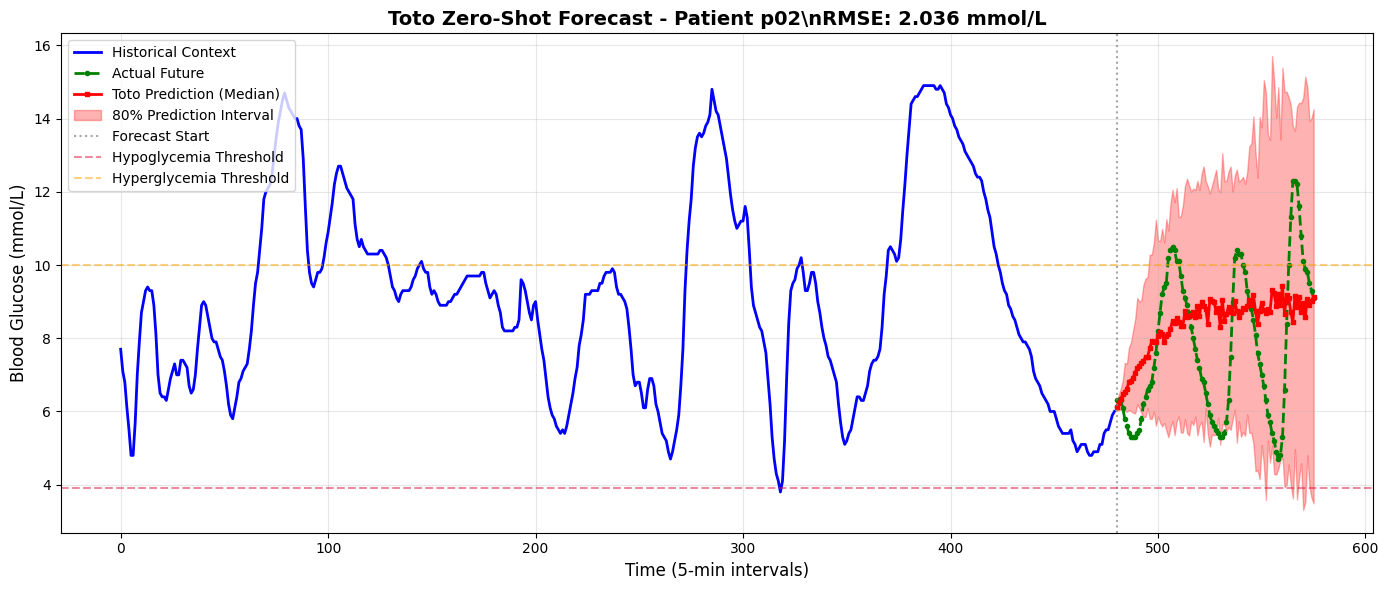

In [13]:
# Visualize predictions for one patient
if len(val_data) > 0:
    # Pick first valid patient
    sample_patient_id = None
    for pid, pdf in val_data.items():
        if pid != "p03" and get_interval_minutes(pdf) == INTERVAL_MINS and len(pdf) >= context_length + prediction_length:
            sample_patient_id = pid
            break
    
    if sample_patient_id:
        print(f"Visualizing predictions for {sample_patient_id}...")
        
        patient_df = val_data[sample_patient_id]
        target_data = patient_df[TARGET_COL].values
        timestamps = patient_df.index
        
        # Take one window from the middle of the data
        mid_idx = len(target_data) // 2
        start_idx = max(0, mid_idx - context_length)
        
        context = target_data[start_idx:start_idx+context_length]
        actual_future = target_data[start_idx+context_length:start_idx+context_length+prediction_length]
        context_timestamps = timestamps[start_idx:start_idx+context_length]
        
        # Skip if NaN values present
        if np.isnan(context).any() or np.isnan(actual_future).any():
            print("Warning: Selected window contains NaN values. Skipping visualization.")
            print("Try selecting a different patient or time window.")
        else:
            # Prepare Toto input
            series_tensor = torch.tensor(context, dtype=torch.float32).unsqueeze(0).to(device)
            padding_mask = torch.ones_like(series_tensor, dtype=torch.bool)
            id_mask = torch.zeros_like(series_tensor)
            timestamp_seconds = torch.tensor(
                [ts.timestamp() for ts in context_timestamps],
                dtype=torch.float32
            ).unsqueeze(0).to(device)
            time_interval = torch.tensor([INTERVAL_MINS * 60], dtype=torch.float32).to(device)
            
            inputs = MaskedTimeseries(
                series=series_tensor,
                padding_mask=padding_mask,
                id_mask=id_mask,
                timestamp_seconds=timestamp_seconds,
                time_interval_seconds=time_interval,
            )
            
            # Make prediction with quantiles
            with torch.no_grad():
                forecast = forecaster.forecast(
                    inputs,
                    prediction_length=prediction_length,
                    num_samples=256,
                    samples_per_batch=64,
                )
                predicted_future = forecast.median.cpu().numpy().flatten()
                q10 = forecast.quantile(0.1).cpu().numpy().flatten()
                q90 = forecast.quantile(0.9).cpu().numpy().flatten()
            
            # Plot
            fig, ax = plt.subplots(figsize=(14, 6))
            
            time_context = np.arange(len(context))
            time_future = np.arange(len(context), len(context) + len(actual_future))
            
            ax.plot(time_context, context, label='Historical Context', color='blue', linewidth=2)
            ax.plot(time_future, actual_future, label='Actual Future', color='green', linestyle='--', linewidth=2, marker='o', markersize=3)
            ax.plot(time_future, predicted_future, label='Toto Prediction (Median)', color='red', linewidth=2, marker='s', markersize=3)
            ax.fill_between(time_future, q10, q90, alpha=0.3, color='red', label='80% Prediction Interval')
            
            ax.axvline(x=len(context), color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='Forecast Start')
            ax.axhline(y=3.9, color='crimson', linestyle='--', alpha=0.5, label='Hypoglycemia Threshold')
            ax.axhline(y=10.0, color='orange', linestyle='--', alpha=0.5, label='Hyperglycemia Threshold')
            
            rmse_window = np.sqrt(np.mean((predicted_future - actual_future) ** 2))
            
            ax.set_xlabel('Time (5-min intervals)', fontsize=12)
            ax.set_ylabel('Blood Glucose (mmol/L)', fontsize=12)
            ax.set_title(f'Toto Zero-Shot Forecast - Patient {sample_patient_id}\\nRMSE: {rmse_window:.3f} mmol/L', fontsize=14, fontweight='bold')
            ax.legend(loc='best', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    else:
        print("No suitable patient found for visualization.")

## Comparison with Baselines

To compare Toto with other models (Chronos, TEMPO, TTM), run those notebooks and compare metrics:

- Chronos notebook: `4.11-tc-amazon-chronos_forecasting.ipynb`
- TEMPO notebook: `4.12-ad-tempo-forecasting.ipynb`
- TTM zero-shot: `4.08-ad-cr-ttm-forecast-zs.ipynb`

Key metrics to compare:
- RMSE (lower is better)
- MAE (lower is better)
- Inference speed
- Probabilistic calibration (for Toto)

## Notes and Observations

**Toto Characteristics:**
- 151M parameter foundation model
- Zero-shot capable (no training required)
- Trained on 2 trillion observability metrics (not healthcare-specific)
- **Probabilistic forecasting** with quantiles (80% prediction intervals)
- Decoder-only transformer architecture

**Implementation Notes:**
- Uses data directly from loader
- Simple, clean implementation following TEMPO/Chronos notebook pattern
- Provides uncertainty estimates via quantiles
- **IMPORTANT**: Unlike Chronos/TEMPO, Toto does NOT handle NaN values internally
  - Must skip or impute NaN values before feeding to model
  - NaN values cause numerical instability in the Student-T distribution
  - Current implementation skips windows containing NaN

**Potential Improvements:**
1. Incorporate exogenous features (COB, IOB) - Toto supports multivariate
2. Fine-tune on diabetes-specific data
3. Experiment with different context lengths
4. Leverage probabilistic predictions for risk assessment
5. Compare with healthcare-focused models (UniTS)
6. Implement proper NaN imputation instead of skipping windows

**Next Steps:**
- Compare with UniTS (healthcare pre-trained)
- Compare with TEMPO and Chronos
- Implement PatchTST for comparison
- Consider ensemble methods

In [ ]:
# Save results for later comparison
if len(patient_metrics) > 0:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_path = f"../../results/toto_zero_shot_{timestamp}.csv"
    
    metrics_df = pd.DataFrame(patient_metrics)
    metrics_df.to_csv(results_path, index=False)
    print(f"Results saved to: {results_path}")